In [297]:
# from google.colab import drive
# drive.mount('/content/drive')

In [298]:
url = 'drive/MyDrive/a/'
url = ''

# Preprocessing

## Importing Libraries

In [299]:
# !pip install hazm

In [397]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import re
from hazm import InformalNormalizer, Normalizer, word_tokenize
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## preprocessing prepared data (taghche.csv)

In [301]:
tqdm.pandas()

In [302]:
prepared_data: pd.DataFrame = pd.read_csv(url + 'datasets/taghche.csv')
prepared_data = prepared_data[['comment', 'bookname', 'bookID']]

In [303]:
prepared_data.head()

,comment,bookname,bookID
0,اسم کتاب No one writes to the Colonel\nترجمش...,سرهنگ کسی ندارد برایش نامه بنویسد,3.0
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",سرهنگ کسی ندارد برایش نامه بنویسد,3.0
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,سرهنگ کسی ندارد برایش نامه بنویسد,3.0
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,سرهنگ کسی ندارد برایش نامه بنویسد,3.0
4,کتاب خوبی است,سرهنگ کسی ندارد برایش نامه بنویسد,3.0


In [304]:
chars_stop_words = ''
with open(url + 'stopwords/chars (without digits).txt', 'r', encoding='utf-8') as file:
    chars_stop_words = ''.join(file.read().splitlines())

chars_stop_words = chars_stop_words.replace('[', '\[')
chars_stop_words = chars_stop_words.replace(']', '\]')
chars_pattern = re.compile(f'[{chars_stop_words}]')
chars_pattern

re.compile(r'[\ufeff!"#()*,-./:\[\]«»،؛؟…$ًٌٍَُِّْءٰٔ﷼]', re.UNICODE)

In [305]:
# https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
emojis_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+")
emojis_pattern

re.compile(r'[😀-🙏🌀-🗿🚀-\U0001f6ff\U0001f1e0-🇿]+', re.UNICODE)

In [306]:
def elementary_preprocess(text):
    global chars_pattern, emojis_pattern

    text = str(text)
    text = chars_pattern.sub(r' ', text)
    text = emojis_pattern.sub(r' ', text)
    return text.translate(str.maketrans('0123456789', '۰۱۲۳۴۵۶۷۸۹'))


def higher_preprocess(text, is_informal=False):
    global normalizer

    text = str(text)
    
    if is_informal:
        text = informal_normalizer_function(text)
    else:
        text = normalizer.normalize(text)
    
    text = word_tokenize(text)
    return text


# customizing InformalNormalizer().normalize()
# For seeing differences, you can see InformalNormalizer().normalize() method
def informal_normalizer_function(text):
    global informal_normalizer
    text = str(text)

    informal_normalizer = InformalNormalizer()
    text = Normalizer.normalize(informal_normalizer, text)
    sents = [
        informal_normalizer.word_tokenizer.tokenize(sentence)
        for sentence in informal_normalizer.sent_tokenizer.tokenize(text)
    ]

    normalized = [[informal_normalizer.normalized_word(word)[0] for word in sent] for sent in sents]
    normalized = np.array(normalized, dtype=object)
    return np.hstack(normalized)

In [307]:
normalizer = Normalizer()
informal_normalizer = InformalNormalizer()

In [308]:
for column in prepared_data.columns:
    if column == 'bookID':
        continue
    
    print(f'Column: {column}')
    prepared_data[column] = prepared_data[column].progress_apply(elementary_preprocess)

Column: comment


  0%|          | 0/69829 [00:00<?, ?it/s]

Column: bookname


  0%|          | 0/69829 [00:00<?, ?it/s]

In [309]:
# When you want to do informal normalization, uncomment following lines
# for column in prepared_data.columns:
#     if column == 'bookID':
#         continue
# 
#     progress_bar = tqdm(total=len(prepared_data[column]))
#     prepared_data[column] = prepared_data[column].progress_apply(lambda x: higher_preprocess(x, True))


for column in prepared_data.columns:
    if column == 'bookID':
        continue
    
    print(f'Column: {column}')
    prepared_data[column] = prepared_data[column].progress_apply(higher_preprocess)

Column: comment


  0%|          | 0/69829 [00:00<?, ?it/s]

Column: bookname


  0%|          | 0/69829 [00:00<?, ?it/s]

In [310]:
# prepared_data.to_csv('datasets/preprocessed/preprocessed_taghche.csv')
# prepared_data = pd.read_csv('datasets/preprocessed/preprocessed_taghche.csv')

In [311]:
before_dropping = len(prepared_data)
prepared_data = prepared_data[prepared_data['comment'].apply(lambda x: len(x)) != 0]
print(f'Dropped {before_dropping - len(prepared_data)} rows with empty comment.')

Dropped 431 rows with empty comment.


In [312]:
before_dropping = len(prepared_data)
prepared_data = prepared_data.dropna(subset=['bookID'])
print(f'Dropped {before_dropping - len(prepared_data)} rows with NaN bookID.')

Dropped 39 rows with NaN bookID.


In [313]:
prepared_data.head()

,comment,bookname,bookID
0,"[اسم, کتاب, No, one, writes, to, the, Colonel,...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0
1,"[طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0
2,"[بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0
3,"[به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0
4,"[کتاب, خوبی, است]","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0


## preprocessing crawled data (books_data_part_*.csv)

In [314]:
ALL_PARTS_LEN = 19
crawled_data: pd.DataFrame = pd.read_csv(url + 'datasets/books data/books_data_part_1.csv')
for i in range(2, ALL_PARTS_LEN + 1):
    crawled_data = pd.concat([crawled_data, pd.read_csv(url + f'datasets/books data/books_data_part_{i}.csv')],
                             ignore_index=True)

In [315]:
# sort authors in order to drop duplicates
new_author_function = lambda x: ' $ '.join(sorted(str(x).split(' $ ')))
crawled_data['author'] = crawled_data['author'].apply(new_author_function)

In [316]:
before_dropping = len(crawled_data)
crawled_data = crawled_data.drop_duplicates()
print(f'Dropped {before_dropping - len(crawled_data)} duplicates.')

Dropped 4 duplicates.


In [317]:
before_dropping = len(crawled_data)
crawled_data = crawled_data.dropna(subset=['id'])
print(f'Dropped {before_dropping - len(crawled_data)} rows with NaN id.')

Dropped 1 rows with NaN id.


In [318]:
new_author_function = lambda x: set(x.split(' $ '))
crawled_data['author'] = crawled_data['author'].apply(new_author_function)

In [319]:
# convert each author to an independent row
# because I want to find each author independently in the comments
crawled_data = crawled_data.explode('author')
crawled_data = crawled_data.reset_index(drop=True)

In [320]:
for column in crawled_data.columns:
    if column == 'id':
        continue
    
    print(f'Column: {column}')
    crawled_data[column] = crawled_data[column].progress_apply(elementary_preprocess)

Column: name


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: author


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: translator


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: publisher


  0%|          | 0/200574 [00:00<?, ?it/s]

In [321]:
for column in crawled_data.columns:
    if column == 'id':
        continue
        
    print(f'Column: {column}')
    crawled_data[column] = crawled_data[column].progress_apply(higher_preprocess)

Column: name


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: author


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: translator


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: publisher


  0%|          | 0/200574 [00:00<?, ?it/s]

In [322]:
# crawled_data.to_csv('datasets/preprocessed/crawled_data.csv')
# crawled_data = pd.read_csv('datasets/preprocessed/crawled_data.csv')

In [323]:
crawled_data.head()

,id,name,author,translator,publisher
0,100.0,"[هفت, گام, برای, شروع, موفق, یک, کسب, و, کار]","[نعیم, ظفر]","[محسن, سحر, حاجیانی, بحریه]","[انتشارات, سازمان, مدیریت, صنعتی]"
1,1000.0,"[آرزوی, شهادت]","[سید, اسماعیل, گوهری]",[nan],"[انتشارات, علمی, فرهنگی, الحیاة]"
2,10000.0,"[شرق, ۱۳۹۵, سه‌شنبه, ۱۸, خرداد]",[nan],[nan],"[روزنامه, شرق]"
3,100000.0,"[محمدعلی, فروغی, و, ساختارهای, نوین, مدنی]","[علی‌اصغر, حقدار]",[nan],"[انتشارات, کویر]"
4,100001.0,"[روزنامه, سازندگی, شماره, ۹۵۷, ۲۲, خرداد, ۱۴۰۰]",[nan],[nan],"[روزنامه, سازندگی]"


## Merging prepared and crawled data

In [324]:
data: pd.DataFrame = pd.merge(prepared_data, crawled_data, left_on='bookID', right_on='id')
data = data.drop(columns=['bookID'])

In [325]:
print(f'Prepared data: {len(prepared_data)}')
print(f'Crawled data: {len(crawled_data)}')
print(f'Merged data: {len(data)}')

Prepared data: 69359
Crawled data: 200574
Merged data: 74386


,comment,bookname,id,name,author,translator,publisher
0,"[اسم, کتاب, No, one, writes, to, the, Colonel,...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]"
1,"[طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]"
2,"[بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]"
3,"[به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]"
4,"[کتاب, خوبی, است]","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]"


In [ ]:
data.head()

In [326]:
# data.to_csv('datasets/preprocessed/data.csv')
# data = pd.read_csv('datasets/preprocessed/data.csv')

In [327]:
crawled_books = set(crawled_data['id'].values)
prepared_books = prepared_data[['bookID']].copy()

unavailable_books = prepared_books[~prepared_books['bookID'].apply(lambda x: x in crawled_books)]
unavailable_books = unavailable_books.drop_duplicates()
print(f'Unavailable books (The page has 404 error): {len(unavailable_books)}')
unavailable_books

Unavailable books (The page has 404 error): 10


,bookID
7458,1.0
7682,2.0
21944,0.0
26052,7.0
30150,6.0
41373,10.0
49272,4.0
52089,30658.0
52636,30925.0
58179,38430.0


In [328]:
with open('unavailable_books_list.txt', 'w', encoding='utf-8') as file:
    unavailable_books_list = unavailable_books['bookID'].values.flatten()
    unavailable_books_list = unavailable_books_list[~np.isnan(unavailable_books_list)]
    unavailable_books_list = unavailable_books_list.astype(int)
    unavailable_books_list = unavailable_books_list.tolist()
    unavailable_books_list = sorted(list(set(unavailable_books_list)))
    file.write(str(unavailable_books_list))

# Labeling

In [329]:
labeled_data = data.copy()
labeled_data['label'] = [[0]] * len(labeled_data)
labeled_data.head()

,comment,bookname,id,name,author,translator,publisher,label
0,"[اسم, کتاب, No, one, writes, to, the, Colonel,...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]",[0]
1,"[طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]",[0]
2,"[بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]",[0]
3,"[به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]",[0]
4,"[کتاب, خوبی, است]","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]",[0]


In [330]:
tags = ['name', 'author', 'translator', 'publisher']

In [331]:
def get_label(tag):
    if tag == 'name':
        return 'Book'
    elif tag == 'author':
        return 'Author'
    elif tag == 'translator':
        return 'Translator'
    elif tag == 'publisher':
        return 'Publisher'
    else:
        return None


def convert_index_to_label(index, tag):
    labels = []

    for i in range(len(index)):
        if index[i] == -1:
            labels.append('O')
        else:
            if i == 0 or index[i - 1] == -1 or index[i] - index[i - 1] != 1:
                labels.append(f'B-{get_label(tag)}')
            else:
                labels.append(f'I-{get_label(tag)}')

    return labels


def combine_labels(labels):
    global tags

    result = []

    for i in range(len(labels[tags[0]])):
        name = labels[tags[0]][i] if len(labels[tags[0]]) > 0 else 'O'
        author = labels[tags[1]][i] if len(labels[tags[1]]) > 0 else 'O'
        translator = labels[tags[2]][i] if len(labels[tags[2]]) > 0 else 'O'
        publisher = labels[tags[3]][i] if len(labels[tags[3]]) > 0 else 'O'

        if name != 'O':
            result.append(name)
        elif author != 'O':
            result.append(author)
        elif translator != 'O':
            result.append(translator)
        elif publisher != 'O':
            result.append(publisher)
        else:
            result.append('O')

    return result


def get_labels(row):
    indexes = {
        tag: []
        for tag in tags
    }
    labels = {
        tag: []
        for tag in tags
    }

    for tag in tags:
        cell = row[tag]
        if cell == {np.nan}:
            continue

        filled_indexes = set()
        for word in row['comment']:
            try:
                current_index = cell.index(word)
                if current_index in filled_indexes:
                    raise ValueError
                indexes[tag].append(current_index)
                filled_indexes.add(current_index)
            except ValueError:
                indexes[tag].append(-1)

        labels[tag] = convert_index_to_label(indexes[tag], tag)

    return combine_labels(labels)

In [332]:
labeled_data['label'] = labeled_data.progress_apply(get_labels, axis=1)

  0%|          | 0/74386 [00:00<?, ?it/s]

In [333]:
# labeled_data.to_csv('datasets/preprocessed/labeled_data.csv', index=False)
# labeled_data = pd.read_csv('datasets/preprocessed/labeled_data.csv')

In [334]:
labeled_data.head()

,comment,bookname,id,name,author,translator,publisher,label
0,"[اسم, کتاب, No, one, writes, to, the, Colonel,...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]","[O, O, O, O, O, O, O, O, O, O, B-Book, O, B-Bo..."
1,"[طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]","[O, O, O, O, B-Book, O, B-Book, B-Book, O, O, ..."
2,"[بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]","[O, O, O, B-Author, O, O, O, O, O, O, O, O, O,..."
3,"[به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[کتاب, خوبی, است]","[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]",3.0,"[سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]","[گابریل, گارسیا, مارکز]","[نازنین, نوذری]","[موسسه, فرهنگی, هنری, نوروز, هنر]","[O, O, O]"


In [404]:
# percentage_of_o = [len([tag for tag in label if tag == 'O']) / len(label) for label in labeled_data['label']]
# fig = px.histogram(percentage_of_o, title='Percentage of O in Each Label List Histogram')
# fig.update_layout(showlegend=False)
# fig.show()

In [336]:
before_dropping = len(labeled_data)
labeled_data = labeled_data[[percentage < 0.99 for percentage in percentage_of_o]]
print(f'Dropped {before_dropping - len(labeled_data)} rows with more than 99% O.')
print(f'New length: {len(labeled_data)}')

Dropped 52894 rows with more than 99% O.
New length: 21492


In [405]:
# fig = px.histogram([tag for label in labeled_data['label'] for tag in label], title='Tag Distribution with O')
# fig.update_layout(showlegend=False)
# fig.show()

In [406]:
# fig = px.histogram([tag for label in labeled_data['label'] for tag in label if tag != 'O'], title='Tag Distribution without O')
# fig.update_layout(showlegend=False)
# fig.show()

# Training The Model (LSTM)

## Importing Libraries

In [339]:
# !pip install tensorflow livelossplot

In [340]:
!mkdir logs
!mkdir resources

mkdir: logs: File exists


In [394]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, SpatialDropout1D, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot.tf_keras import PlotLossesCallback

In [342]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.13.1
GPU detected: []


## Exploring Data

In [343]:
# labeled_data = pd.read_csv('datasets/preprocessed/labeled_data.csv')

In [369]:
words = list(set([word for comment in labeled_data['comment'] for word in comment]))
words.append('STARTPAD')
words_size = len(words)
words_size

49137

In [370]:
tags = sorted(list(set([tag for label in labeled_data['label'] for tag in label])))
tags_size = len(tags)
tags_size, tags

(9,
 ['B-Author',
  'B-Book',
  'B-Publisher',
  'B-Translator',
  'I-Author',
  'I-Book',
  'I-Publisher',
  'I-Translator',
  'O'])

## Changing Data Format

In [371]:
sentences = labeled_data.progress_apply(
    lambda row: [(word, label) for word, label in zip(row['comment'], row['label'])], axis=1)
sentences = sentences.progress_apply(lambda sentence: sentence + [('STARTPAD', 'O')])

  0%|          | 0/21492 [00:00<?, ?it/s]

  0%|          | 0/21492 [00:00<?, ?it/s]

In [372]:
# sentences.to_csv('datasets/preprocessed/sentences.csv', index=False)
# sentences = pd.read_csv('datasets/preprocessed/sentences.csv')['0']

## Convert Words and Labels to Numbers

In [373]:
word2idx = {word: idx for idx, word in enumerate(words)}
tag2idx = {tag: idx for idx, tag in enumerate(tags)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [374]:
tag2idx

{'B-Author': 0,
 'B-Book': 1,
 'B-Publisher': 2,
 'B-Translator': 3,
 'I-Author': 4,
 'I-Book': 5,
 'I-Publisher': 6,
 'I-Translator': 7,
 'O': 8}

## Padding the Sentences

In [403]:
# fig = px.histogram([len(sentence) for sentence in sentences], title='Sentence Length Histogram')
# fig.update_layout(showlegend=False)
# fig.show()

In [376]:
# Based on the last hist.
max_length = 210

comments_less_than_max_length = len([sentence for sentence in sentences if len(sentence) <= max_length])
print(f'Number of comments less than {max_length}: {comments_less_than_max_length}')
print(f'Remainder: {len(sentences) - comments_less_than_max_length}')

Number of comments less than 210: 21203
Remainder: 289


In [377]:
X = [[word2idx[word[0]] for word in sentence] for sentence in sentences]
X = pad_sequences(X, maxlen=max_length, padding='post', value=words_size-1)

y = [[tag2idx[word[1]] for word in sentence] for sentence in sentences]
y = pad_sequences(y, maxlen=max_length, padding='post', value=tag2idx['O'])

In [378]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [379]:
print(f'Train size: {len(X_train)}\nValidation size: {len(X_val)}\nTest size: {len(X_test)}')

Train size: 17193
Validation size: 2149
Test size: 2150


## Bidirectional LSTM Model

In [380]:
model = Sequential()
model.add(InputLayer(max_length))
model.add(Embedding(input_dim=words_size, output_dim=max_length, input_length=max_length))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 210, 210)          10318770  
                                                                 
 spatial_dropout1d_7 (Spati  (None, 210, 210)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_7 (Bidirecti  (None, 210, 600)          1226400   
 onal)                                                           
                                                                 
Total params: 11545170 (44.04 MB)
Trainable params: 11545170 (44.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


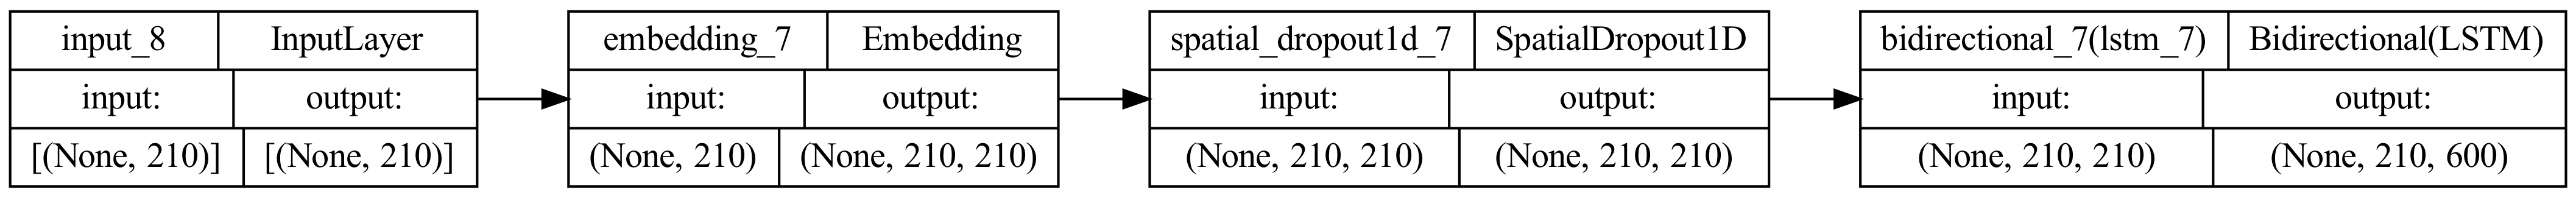

In [381]:
tf.keras.utils.plot_model(
    model, to_file='resources/model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

In [382]:
logdir = 'logs/'
tensorboard_callback = TensorBoard(log_dir=logdir)

model_checkpoint = ModelCheckpoint('resources/model.keras', monitor='val_loss', verbose=1, save_best_only=True,
                                   save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=1, mode='max', baseline=None)
plot_losses = PlotLossesCallback()

In [383]:
history = model.fit(X_train[:10], y_train[:10], validation_data=(X_val[:10], y_val[:10]), batch_size=32, epochs=3, verbose=1,
                    callbacks=[tensorboard_callback, model_checkpoint, early_stopping, plot_losses])

accuracy
	training         	 (min:    0.000, max:    0.055, cur:    0.055)
	validation       	 (min:    0.011, max:    0.944, cur:    0.944)
Loss
	training         	 (min:    4.235, max:   17.024, cur:    4.235)
	validation       	 (min:    2.899, max:   14.977, cur:    2.899)
1/1 [==============================] - 1s 1s/step - loss: 4.2347 - accuracy: 0.0552 - val_loss: 2.8990 - val_accuracy: 0.9443


In [384]:
# model.save('resources/model.keras')
# model = tf.keras.models.load_model('resources/model.keras')

## Evaluation

In [385]:
def pred_y(x):
    p = model.predict(np.array([x]))
    p = np.argmax(p, axis=-1)
    return p

def print_prediction(x, y):
    print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
    print("-" *30)
    for w, true, pred in zip(x, y, pred_y(x)):
        try:
            print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))
        except IndexError:
            print("{:15}{}\t{}".format(words[w-1], tags[true], 'O'))

In [387]:
sample_X = 'من پارسال موقع عید کتاب جز از کل رو از انتشارات چشمه خوندم باید بگم که موقع خوندنش واقعاً محو قلم استیو تولتز شده بودم.'
sample_X = higher_preprocess(elementary_preprocess(sample_X))
sample_X = [[word2idx[word] if word in word2idx else -1 for word in sample_X]]
sample_X = pad_sequences(sample_X, maxlen=max_length, padding='post', value=words_size-1)

p = pred_y(sample_X[0])
print("{:15}\t {}\n".format("Word", "Pred"))
print("-" *30)
for w, pred in zip(sample_X[0], p[0]):
    try:
        print("{:15}\t{}".format(words[w-1], tags[pred]))
    except IndexError:
        print("{:15}\t{}".format(words[w-1], 'O'))

1/1 [==============================] - 0s 67ms/step
Word           	 Pred

------------------------------
بخوندنش        	O
اینان          	O
عایدی          	O
جرأت           	O
فوق‎العادیه    	O
ندزدید         	O
می‌گذره        	O
مقدم           	O
خوون‌ها        	O
می‌گذره        	O
خودگذشتی       	O
میرشکار        	O
مؤمنه          	O
ربذه           	O
جاری           	O
طمانینه        	O
عایدی          	O
جزیاتش         	O
مرگشه          	O
فیدبوئه        	O
انگیزترین‌ها   	O
رئوف           	O
مسقیما         	O
کافیه‌ی        	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ       	O
فیلترینگ    

In [388]:
i = np.random.randint(0, X_test.shape[0])
print("This is sentence:",i)
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)

print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_test[i], p[0]):
    try:
        print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))
    except IndexError:
        print("{:15}{}\t{}".format(words[w-1], tags[true], 'O'))

This is sentence: 428
1/1 [==============================] - 0s 29ms/step
Word           True 	 Pred

------------------------------
دیکنز          O	O
میکنندو        O	O
اموزش          O	O
وخش            O	O
چراولادت       B-Author	O
گمشده‌ام       O	O
همکارش         O	O
اکنونی         O	O
ایشان_یادداشت  O	O
مارکو          O	O
تندتند         O	O
استناد         O	O
تفسیرشان       O	O
نقطعه          O	O
صحیح‌تر        O	O
فوق‎العادیه    O	O
استناد         O	O
کلماتشه        O	O
وداع           O	O
جسور           O	O
مهر            O	O
وبیان          O	O
همکارش         O	O
میرسوندن       O	O
مهمیو          O	O
توبه           O	O
بخوندنش        O	O
همانطور        O	O
مهربانم        O	O
میشید<<        O	O
مچاله          O	O
azizi          O	O
ارتباطت        O	O
میشید<<        O	O
بچم            O	O
انگیزترین‌ها   O	O
اباالفضل       O	O
میچسبه         O	O
همکارش         O	O
نقطعه          O	O
جالبن          O	O
بایگانی        O	O
حریص‌تر        O	O
رنجوری         O	O
فوق‎العادیه    O	O
بچم  

In [389]:
y_pred = model.predict(X_test)

68/68 [==============================] - 18s 265ms/step


In [393]:
y_pred_index = np.argmax(y_pred, axis=-1)

X_test_list = X_test.tolist()
y_test_list = y_test.tolist()
y_pred_list = y_pred_index.tolist()

start_pad_index = word2idx['STARTPAD']
# progress_bar = tqdm(range(len(X_test)))
for i in range(len(X_test_list)):
    x_start_pad = X_test_list[i].index(start_pad_index)
    X_test_list[i] = X_test_list[i][:x_start_pad]
    y_test_list[i] = y_test_list[i][:x_start_pad]
    
    y_pred_list[i] = y_pred_list[i][:x_start_pad]
    y_pred_list[i] = [tag if tag <= 8 else 8 for tag in y_pred_list[i]]


y_test_flatten = []
for y in y_test_list:
    y_test_flatten.extend(y)

y_pred_flatten = []
for y in y_pred_list:
    y_pred_flatten.extend(y)

print(classification_report(y_test_flatten, y_pred_flatten))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       449
           1       0.00      0.00      0.00      2033
           2       0.20      0.00      0.00       483
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00       155
           5       0.00      0.00      0.00       319
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00        12
           8       0.96      0.99      0.98     76744

    accuracy                           0.95     80277
   macro avg       0.13      0.11      0.11     80277
weighted avg       0.92      0.95      0.93     80277



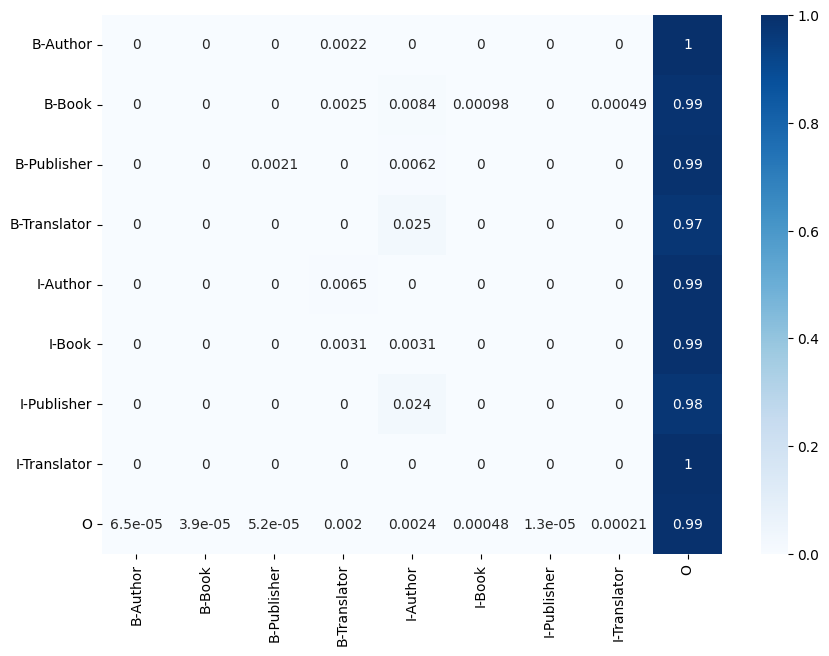

In [399]:
cm = confusion_matrix(y_test_flatten, y_pred_flatten)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, xticklabels=tags, yticklabels=tags, cmap='Blues')
plt.show()

In [402]:
print('Accuracy:', accuracy_score(y_test_flatten, y_pred_flatten))
print()
print('Micro Precision:', precision_score(y_test_flatten, y_pred_flatten, average='micro'))
print('Macro Precision:', precision_score(y_test_flatten, y_pred_flatten, average='macro'))
print('Weighted Precision:', precision_score(y_test_flatten, y_pred_flatten, average='weighted'))
print()
print('Micro Recall:', recall_score(y_test_flatten, y_pred_flatten, average='micro'))
print('Macro Recall:', recall_score(y_test_flatten, y_pred_flatten, average='macro'))
print('Weighted Recall:', recall_score(y_test_flatten, y_pred_flatten, average='weighted'))
print()
print('Micro F1-score:', f1_score(y_test_flatten, y_pred_flatten, average='micro'))
print('Macro F1-score:', f1_score(y_test_flatten, y_pred_flatten, average='macro'))
print('Weighted F1-score:', f1_score(y_test_flatten, y_pred_flatten, average='weighted'))

Accuracy: 0.9509074828406642

Micro Precision: 0.9509074828406642
Macro Precision: 0.12846483701393327
Weighted Precision: 0.9153051193514412

Micro Recall: 0.9509074828406642
Macro Recall: 0.11074899850173034
Weighted Recall: 0.9509074828406642

Micro F1-score: 0.9509074828406642
Macro F1-score: 0.10879397571261952
Weighted F1-score: 0.932160130134861
